<a href="https://www.kaggle.com/code/junaid512/heart-disease-prediction-complete-ml-pipeline?scriptVersionId=248684954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
cherngs_heart_disease_cleveland_uci_path = kagglehub.dataset_download('cherngs/heart-disease-cleveland-uci')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv


## 📚 1. Import Libraries

In [1]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


## 📥 2. Load Dataset

In [4]:
df = pd.read_csv("/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0



## 🧾 3. Dataset Overview

In [5]:

print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [6]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [7]:
print("\nClass Balance:\n", df['condition'].value_counts(normalize=True))


Class Balance:
 condition
0    0.538721
1    0.461279
Name: proportion, dtype: float64



## 📊 4. Exploratory Data Analysis (EDA)

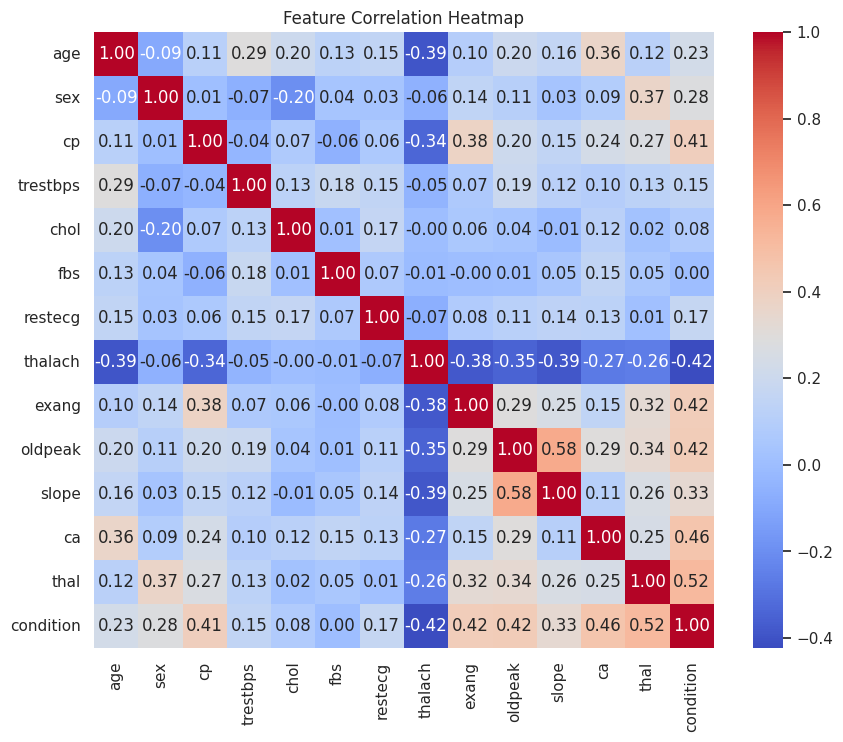

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


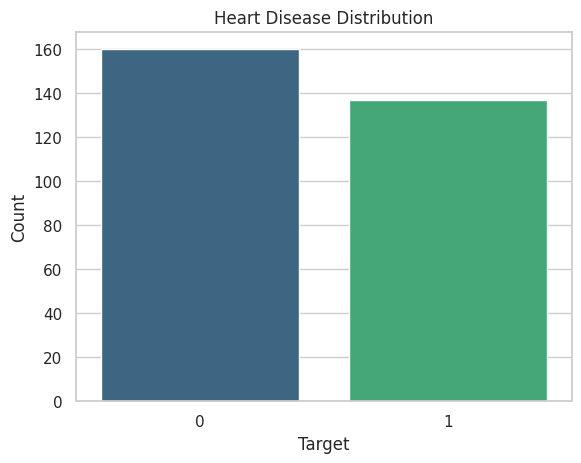

In [9]:
sns.countplot(data=df, x='condition', palette='viridis')
plt.title("Heart Disease Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [10]:
# Create a copy of the dataframe to avoid modifying the original
df_labeled = df.copy()

# Map condition values to descriptive labels
df_labeled['condition'] = df_labeled['condition'].map({0: '0 : no disease', 1: '1: disease'})

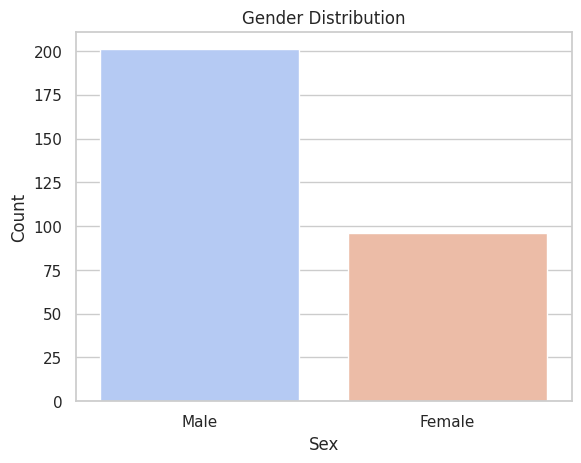

In [40]:
# Replace numeric sex with labels (optional for plotting)
df['SexLabel'] = df['sex'].map({1: 'Male', 0: 'Female'})

# Plot count of Male vs Female
sns.countplot(data=df, x='SexLabel', palette='coolwarm')
plt.title("Gender Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()


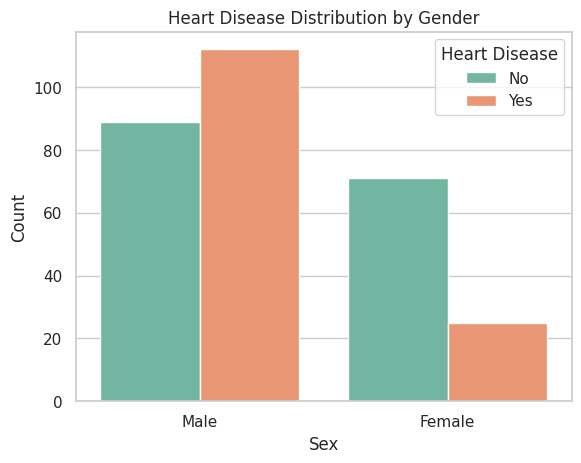

In [42]:
# Count plot of heart disease vs gender
sns.countplot(data=df, x='SexLabel', hue='condition', palette='Set2')
plt.title("Heart Disease Distribution by Gender")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()


In [44]:
# Crosstab for exact counts
gender_disease_count = pd.crosstab(df['SexLabel'], df['condition'])
gender_disease_count.columns = ['No Disease', 'Has Disease']

print("📊 Heart Disease Count by Gender:")
print(gender_disease_count)


📊 Heart Disease Count by Gender:
          No Disease  Has Disease
SexLabel                         
Female            71           25
Male              89          112


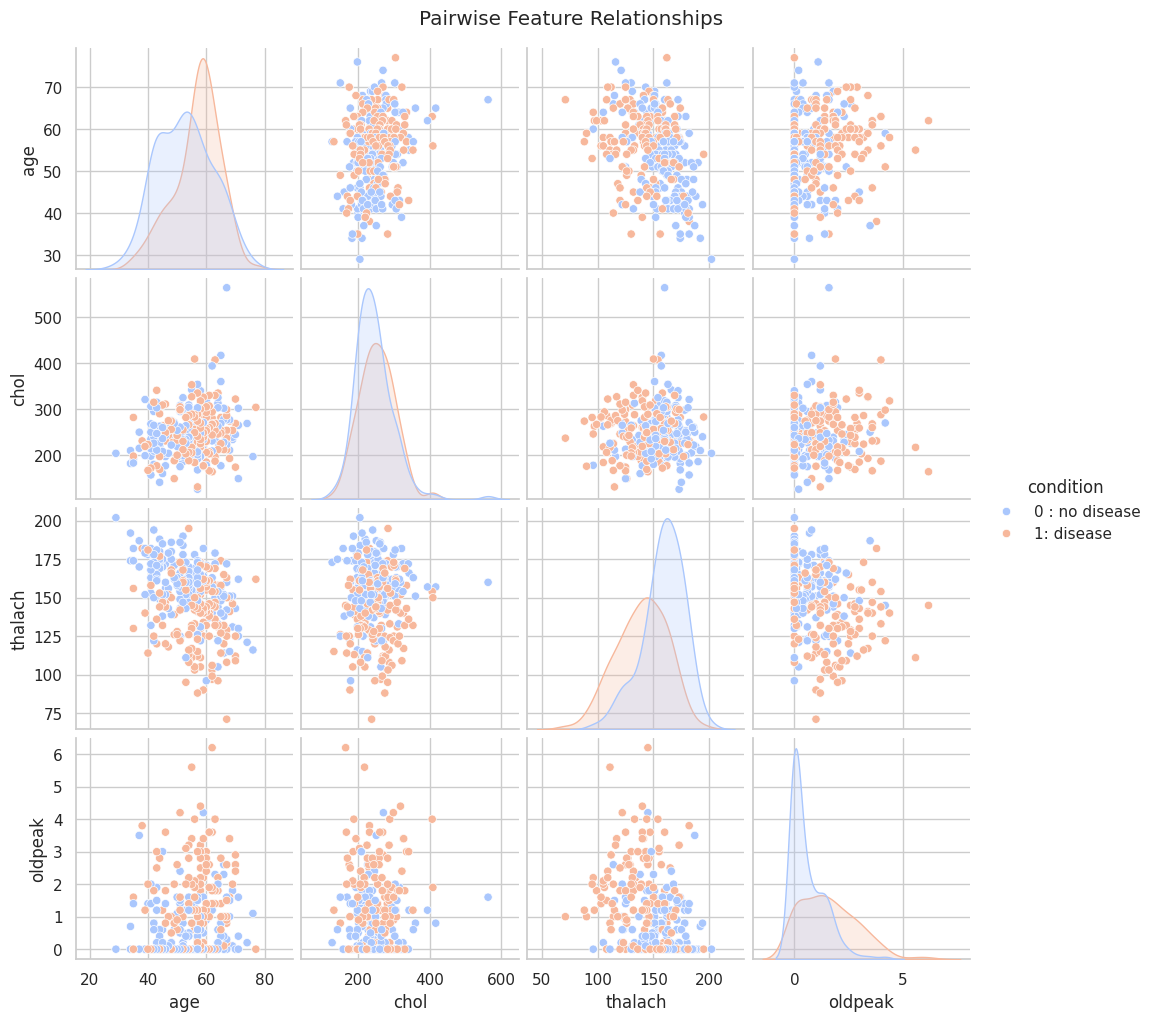

In [11]:
sns.pairplot(df_labeled[['age', 'chol', 'thalach', 'oldpeak', 'condition']], hue='condition', palette='coolwarm')
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

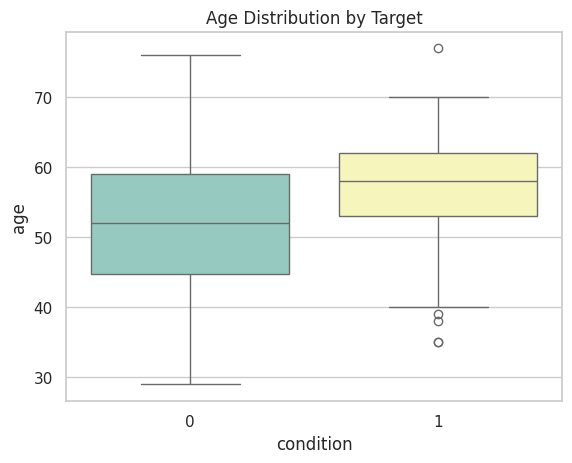

In [12]:

sns.boxplot(data=df, x='condition', y='age', palette='Set3')
plt.title("Age Distribution by Target")
plt.show()

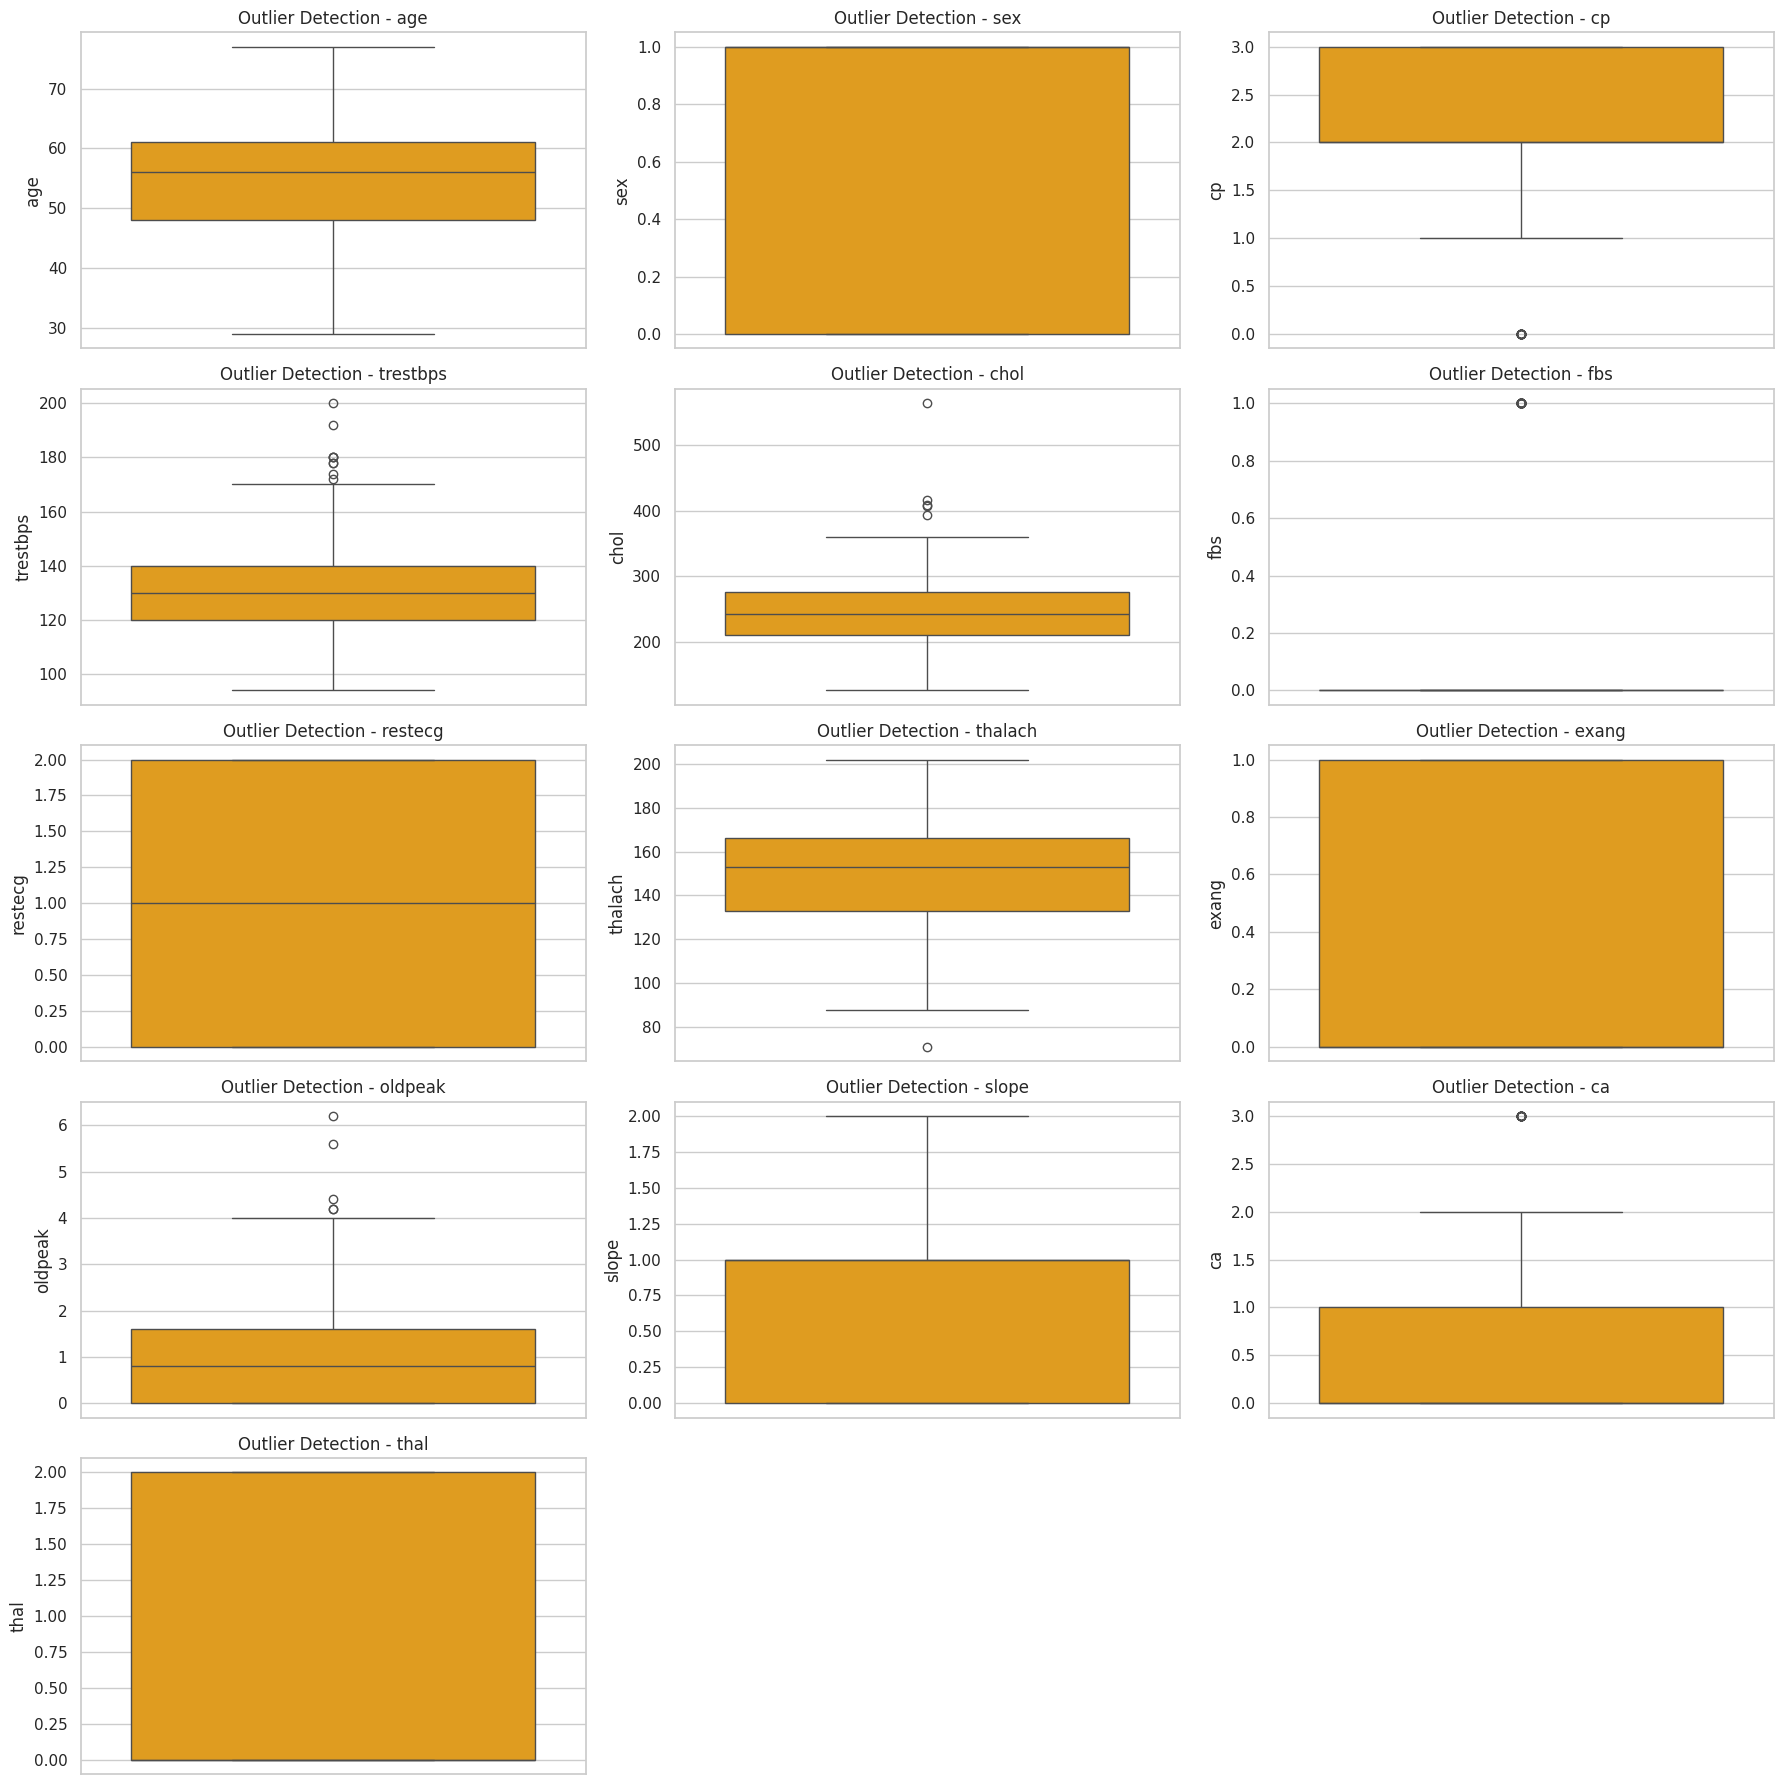

In [13]:
## 📌 Outlier Detection (Boxplots)
plt.figure(figsize=(18, 18)) # Increased figure size to accommodate more subplots
for idx, column in enumerate(df.drop('condition', axis=1).columns):
    plt.subplot(5, 3, idx + 1) # Changed to 5 rows and 3 columns to fit 13 plots
    sns.boxplot(y=df[column], color='orange')
    plt.title(f"Outlier Detection - {column}")
    plt.tight_layout()
plt.show()

In [54]:
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,SexLabel
238,56,0,3,134,409,0,2,150,1,1.9,1,2,2,1,Female
65,41,0,1,105,198,0,0,168,0,0.0,0,1,0,0,Female
241,55,1,3,160,289,0,2,145,1,0.8,1,1,2,1,Male
226,57,1,3,152,274,0,0,88,1,1.2,1,1,2,1,Male
43,54,1,1,108,309,0,0,156,0,0.0,0,0,2,0,Male



## 🧹 5. Preprocessing

In [14]:
X = df.drop('condition', axis=1)
y = df['condition']

In [15]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


## ⚙️ 6. Model Training

In [16]:
# Random Forest Tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [4, 8, None], 'min_samples_split': [2, 5]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
gs_rf.fit(X_train, y_train)
model_rf = gs_rf.best_estimator_


In [17]:

# LightGBM Tuning
lgbm_params = {'num_leaves': [15, 31], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}
gs_lgbm = GridSearchCV(LGBMClassifier(random_state=42), lgbm_params, cv=5, scoring='roc_auc')
gs_lgbm.fit(X_train, y_train)
model_lgbm = gs_lgbm.best_estimator_


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [18]:

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [19]:
# Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('lgbm', model_lgbm),
    ('lr', model_lr)
], voting='soft')

voting_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 128, number of negative: 128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=8,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05, num_leaves=15,
                                             random_state=42)),
                             ('lr', LogisticRegression(max_iter=1000))],
                 voting='soft')

In [20]:

# Stacking Classifier
stack_model = StackingClassifier(estimators=[
    ('rf', model_rf),
    ('lgbm', model_lgbm),
    ('lr', model_lr)
], final_estimator=LogisticRegression(), cv=5)

stack_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 128, number of negative: 128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=8,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.05,
                                               num_leaves=15,
                                               random_state=42)),
                               ('lr', LogisticRegression(max_iter=1000))],
                   final_estimator=LogisticRegression())

## 📈 7. Model Evaluation

In [21]:
## 📈 7. Model Evaluation
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n📊 {name} Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return y_prob


📊 Random Forest Evaluation
Accuracy: 0.828125
ROC AUC: 0.888671875
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        32
           1       0.80      0.88      0.84        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



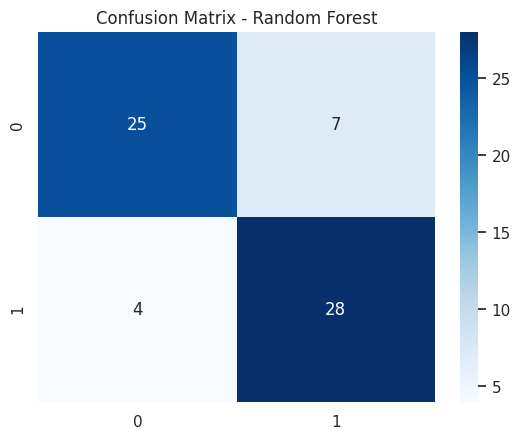


📊 LightGBM Evaluation
Accuracy: 0.828125
ROC AUC: 0.884765625
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        32
           1       0.80      0.88      0.84        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



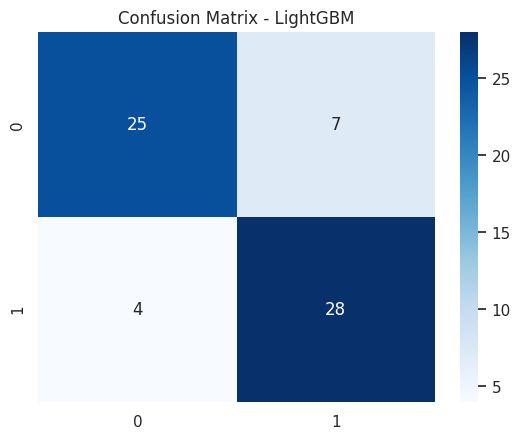


📊 Logistic Regression Evaluation
Accuracy: 0.796875
ROC AUC: 0.8583984375
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78        32
           1       0.76      0.88      0.81        32

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64



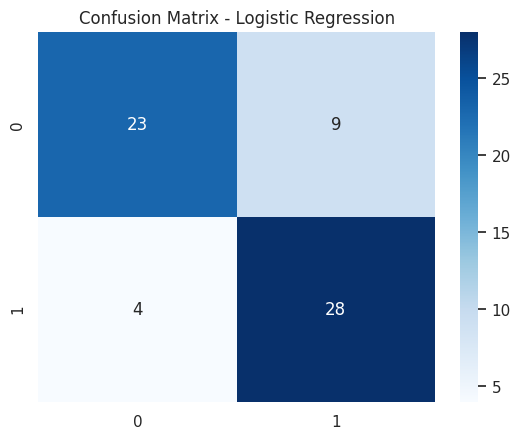


📊 VotingClassifier Evaluation
Accuracy: 0.828125
ROC AUC: 0.8798828125
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        32
           1       0.80      0.88      0.84        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



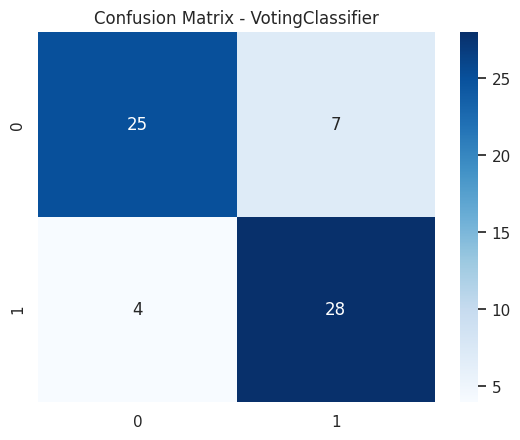


📊 StackingClassifier Evaluation
Accuracy: 0.8125
ROC AUC: 0.876953125
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
           1       0.78      0.88      0.82        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



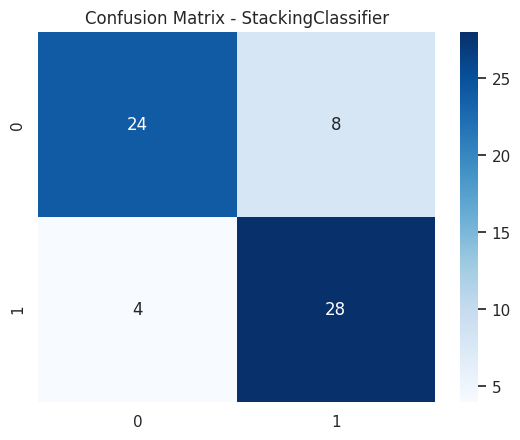

In [22]:

y_prob_rf = evaluate_model(model_rf, X_test, y_test, "Random Forest")
y_prob_lgbm = evaluate_model(model_lgbm, X_test, y_test, "LightGBM")
y_prob_lr = evaluate_model(model_lr, X_test, y_test, "Logistic Regression")
y_prob_vote = evaluate_model(voting_model, X_test, y_test, "VotingClassifier")
y_prob_stack = evaluate_model(stack_model, X_test, y_test, "StackingClassifier")

## 📉 8. ROC Curve

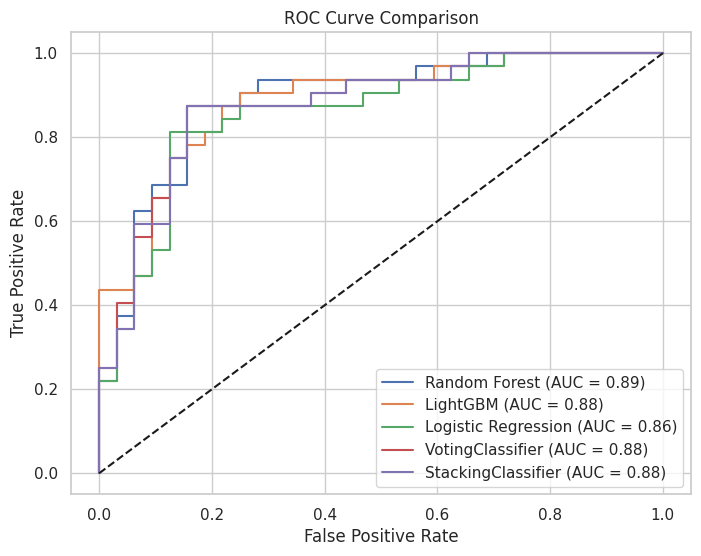

In [23]:

## 📉 8. ROC Curve
plt.figure(figsize=(8, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})")

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC = {roc_auc_score(y_test, y_prob_lgbm):.2f})")

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})")

fpr_vote, tpr_vote, _ = roc_curve(y_test, y_prob_vote)
plt.plot(fpr_vote, tpr_vote, label=f"VotingClassifier (AUC = {roc_auc_score(y_test, y_prob_vote):.2f})")

fpr_stack, tpr_stack, _ = roc_curve(y_test, y_prob_stack)
plt.plot(fpr_stack, tpr_stack, label=f"StackingClassifier (AUC = {roc_auc_score(y_test, y_prob_stack):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


# 📊 9. Summary Table

In [24]:
print("\n✅ Final Model Summary")
print("----------------------------")
print(f"Random Forest       -> Accuracy: {accuracy_score(y_test, model_rf.predict(X_test)):.4f}, AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"LightGBM            -> Accuracy: {accuracy_score(y_test, model_lgbm.predict(X_test)):.4f}, AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")
print(f"Logistic Regression -> Accuracy: {accuracy_score(y_test, model_lr.predict(X_test)):.4f}, AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"VotingClassifier    -> Accuracy: {accuracy_score(y_test, voting_model.predict(X_test)):.4f}, AUC: {roc_auc_score(y_test, y_prob_vote):.4f}")
print(f"StackingClassifier  -> Accuracy: {accuracy_score(y_test, stack_model.predict(X_test)):.4f}, AUC: {roc_auc_score(y_test, y_prob_stack):.4f}")




✅ Final Model Summary
----------------------------
Random Forest       -> Accuracy: 0.8281, AUC: 0.8887
LightGBM            -> Accuracy: 0.8281, AUC: 0.8848
Logistic Regression -> Accuracy: 0.7969, AUC: 0.8584
VotingClassifier    -> Accuracy: 0.8281, AUC: 0.8799
StackingClassifier  -> Accuracy: 0.8125, AUC: 0.8770


## 💾 10. Save Models

In [25]:
joblib.dump(model_rf, "heart_rf_model.pkl")

['heart_rf_model.pkl']

## 🧠 11. User Prediction Function

In [55]:
def predict_user_rf(model, scaler):
    print("\n🔍 Enter Patient Info to Predict Heart Disease Risk:")

    features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

    input_values = []
    for feature in features:
        val = float(input(f"{feature}: "))
        input_values.append(val)

    # Create input DataFrame
    user_df = pd.DataFrame([input_values], columns=features)

    # Scale the data
    user_scaled = scaler.transform(user_df)

    # Predict using the model
    prediction = model.predict(user_scaled)[0]
    probability = model.predict_proba(user_scaled)[0][1]

    print("\n🩺 Prediction Result (Random Forest):")
    if prediction == 1:
        print(f"⚠️ High Risk of Heart Disease. Probability: {probability:.2%}")
    else:
        print(f"✅ Low Risk. Probability: {1 - probability:.2%}")

In [56]:
predict_user_rf(model_rf, scaler)



🔍 Enter Patient Info to Predict Heart Disease Risk:
age: 56
sex: 0
cp: 3
trestbps: 134
chol: 409
fbs: 0
restecg: 2
thalach: 150
exang: 1
oldpeak: 1.9
slope: 1
ca: 2
thal: 2

🩺 Prediction Result (Random Forest):
⚠️ High Risk of Heart Disease. Probability: 95.77%
